# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# CUDA?

print(torch.__version__)

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

2.0.0.dev20230127+cu118
CUDA Available? True


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
from model import Net

2.0.0.dev20230127+cu118
CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm_type="nn.BatchNorm2d").to(device)
summary(model, input_size=(1, 28, 28))

cuda


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,train_losses=[],train_acc=[]):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  return train_losses,train_acc

def test(model, device, test_loader,test_losses=[],test_acc=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses,test_acc

**Group Normalization**

In [8]:
# model =  Net(norm_type="nn.GroupNorm").to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train_losses_gn = []
# test_losses_gn = []
# train_acc_gn = []
# test_acc_gn = []

# EPOCHS = 20
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train_losses_bn,train_acc_bn = train(model, device, train_loader, optimizer, epoch,train_losses_gn,train_acc_gn)
#     test_losses_bn ,test_acc_bn = test(model, device, test_loader,test_losses_gn,test_acc_gn)

**Layer Normalization**

In [9]:
model =  Net(norm_type="nn.LayerNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses_gn = []
test_losses_gn = []
train_acc_gn = []
test_acc_gn = []

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses_bn,train_acc_bn = train(model, device, train_loader, optimizer, epoch,train_losses_gn,train_acc_gn)
    test_losses_bn ,test_acc_bn = test(model, device, test_loader,test_losses_gn,test_acc_gn)

EPOCH: 0


Loss=0.2480197548866272 Batch_id=468 Accuracy=84.40: 100%|██████████| 469/469 [00:03<00:00, 129.15it/s] 



Test set: Average loss: 0.1084, Accuracy: 9754/10000 (97.54%)

EPOCH: 1


Loss=0.08349448442459106 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:04<00:00, 105.67it/s] 



Test set: Average loss: 0.0556, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.03844268247485161 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:04<00:00, 103.25it/s] 



Test set: Average loss: 0.0381, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.09937115758657455 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:04<00:00, 105.84it/s] 



Test set: Average loss: 0.0443, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.029962973669171333 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:04<00:00, 105.18it/s]



Test set: Average loss: 0.0358, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.0394446887075901 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:04<00:00, 105.78it/s]  



Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.1007351353764534 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:04<00:00, 102.79it/s]  



Test set: Average loss: 0.0259, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.005919577553868294 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:04<00:00, 100.33it/s]



Test set: Average loss: 0.0286, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.02503219246864319 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:05<00:00, 86.03it/s]   



Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.0895652174949646 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:05<00:00, 88.26it/s]    



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.049456432461738586 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:05<00:00, 87.40it/s]  



Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.050898477435112 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:05<00:00, 88.10it/s]     



Test set: Average loss: 0.0259, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.006485752295702696 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:05<00:00, 87.16it/s]  



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.03156301751732826 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:05<00:00, 89.72it/s]   



Test set: Average loss: 0.0258, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.02645152620971203 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:05<00:00, 89.40it/s]   



Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.04415860399603844 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:05<00:00, 90.83it/s]   



Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.02449878491461277 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:05<00:00, 88.73it/s]   



Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.01215216051787138 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:05<00:00, 90.72it/s]   



Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.01823091320693493 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:05<00:00, 90.98it/s]   



Test set: Average loss: 0.0218, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.0076566641218960285 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:05<00:00, 90.56it/s] 



Test set: Average loss: 0.0194, Accuracy: 9946/10000 (99.46%)



**L1 Regularization + Batch Normalization**
 

Estimation of Regularisation Coefficient - lambda_l1

Train for one epoch
Get the loss function and sum of model parameters
To make addition term as 0.1*loss , find lambda_l1 = 0.1*loss/sum of parameters

In [10]:
# model =  Net(norm_type="nn.BatchNorm2d").to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# EPOCHS = 1
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

In [11]:
# loss=0.15165962278842926
# sum_params = 0

# for param in model.parameters():
#     sum_params = sum_params + param.abs().sum()

# lambda_l1_tensor = (loss*0.1)/sum_params

# lambda_l1 = float(lambda_l1_tensor.cpu().detach().numpy())

# from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=lambda_l1)

# train_losses_bn = []
# test_losses_bn = []
# train_acc_bn = []
# test_acc_bn = []

# EPOCHS = 20
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train_losses_bn,train_acc_bn = train(model, device, train_loader, optimizer, epoch,train_losses_bn,train_acc_bn)
#     test_losses_bn ,test_acc_bn = test(model, device, test_loader,test_losses_bn,test_acc_bn)

**Plots**

Text(0.5, 1.0, 'Training Accuracy')

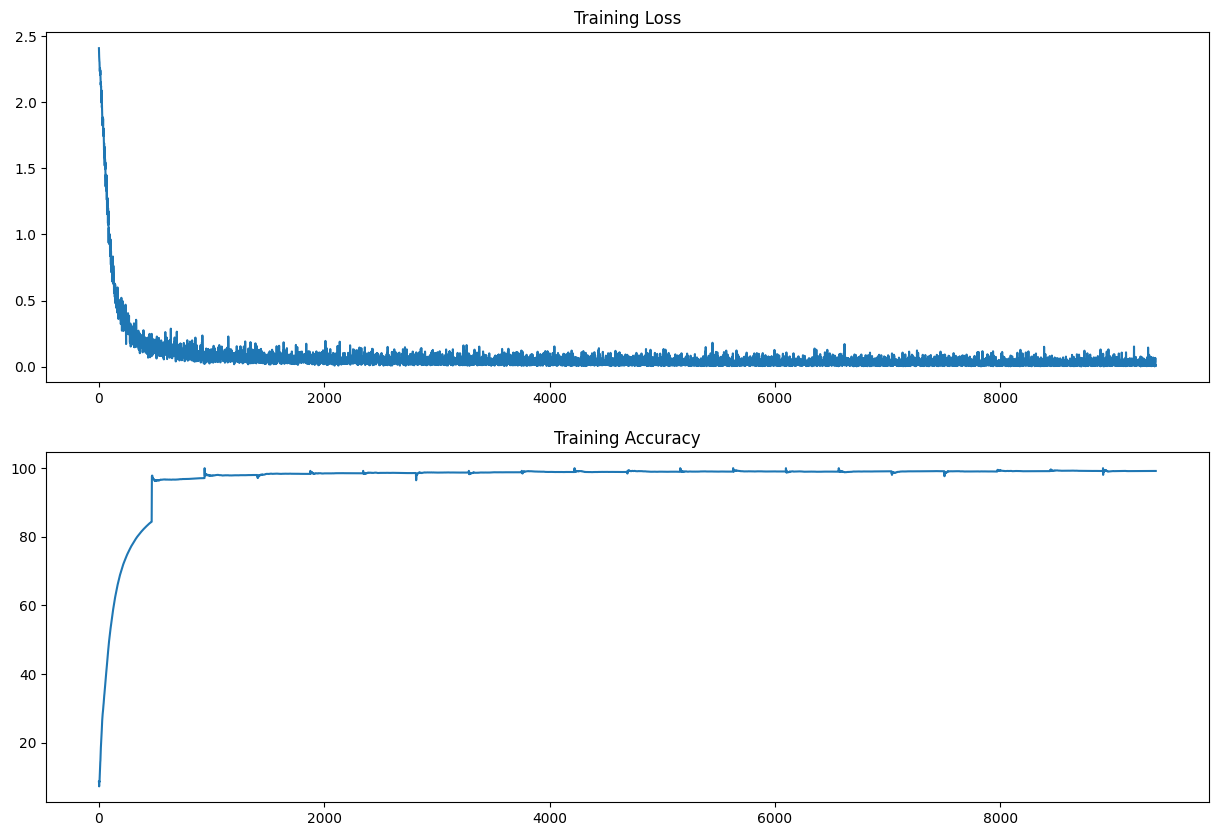

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(15,10))

train_losses_bn = torch.tensor(train_losses_bn, device = 'cpu')

axs[0].plot(train_losses_bn)
axs[0].set_title("Training Loss")


axs[1].plot(train_acc_bn)
axs[1].set_title("Training Accuracy")